In [1]:
import cv2
import os
import numpy as np

In [2]:
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

#loading haarcascade_profileface.xml
profile_model = cv2.CascadeClassifier('haarcascade_profileface.xml')

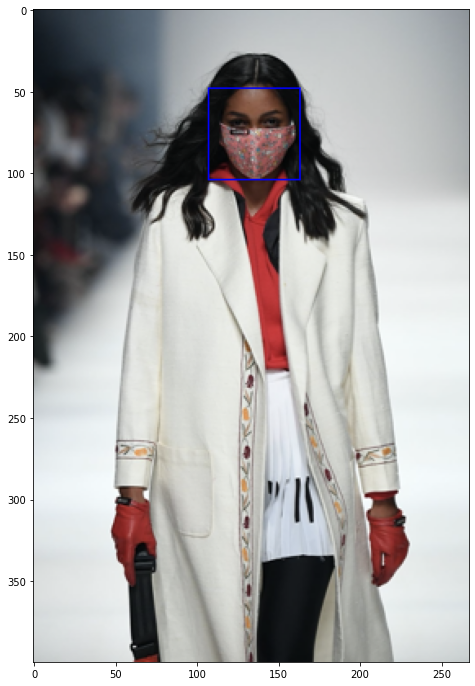

In [14]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('face-mask-detection/images/maksssksksss220.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(0,0,255),1)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

In [ ]:
train_dir = 'face-mask-12k/Train'
test_dir = 'face-mask-12k/Test'
val_dir = 'face-mask-12k/Validation'

In [ ]:
im = cv2.imread(train_dir + '/WithMask/1004.png')

im.shape

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.callbacks import EarlyStopping

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')

In [ ]:
vgg19 = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=(128, 128, 3)
)

for layer in vgg19.layers:
    layer.trainable = False

model = Sequential(layers=vgg19.layers)
model.add(Flatten())
model.add(Dense(2, activation='sigmoid'))
model.summary()

In [ ]:
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics="accuracy",
)

In [ ]:
model.fit(
        train_generator,
        steps_per_epoch=len(train_generator)//32,
        epochs=20,
        validation_data=validation_generator,
        validation_steps=len(validation_generator)//32,
        callbacks=[
            EarlyStopping(monitor='accuracy', mode='min', verbose=1, patience=4)
        ],
)

In [ ]:
model.evaluate(test_generator)

In [ ]:
model.save('masknet.h5')

In [3]:
from keras.models import load_model
model = load_model('masknet.h5')

Metal device set to: Apple M1


2022-04-11 17:10:31.536255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-11 17:10:31.536354: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
mask_label = {0: 'MASK', 1: 'NO MASK'}
color_label = {0: (255, 0, 0), 1: (0, 255, 0)}

no_mask = cv2.imread('face-mask-detection/images/maksssksksss217.png')

mask = cv2.imread('face-mask-detection/images/maksssksksss220.png')

for img in [mask, no_mask]:
    faces = face_model.detectMultiScale(img ,scaleFactor=1.1, minNeighbors=4)
    
    new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    for x, y, w, h in faces:
        cropped = cv2.resize(img[y:y+h, x:x+w], (128, 128))
        cropped = np.reshape(cropped, [1, 128, 128, 3])
        y_pred = model.predict(cropped)
        cv2.putText(new_img,
                    mask_label[y_pred.argmax()],
                    (x,y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color_label[y_pred.argmax()])
        cv2.rectangle(new_img, (x,y), (x+w,y+h), color_label[y_pred.argmax()], 1)
        
    plt.figure(figsize=(10,10))
    plt.imshow(new_img)
        

In [15]:
def intersect(a, b):
    x = max(a[0], b[0])
    y = max(a[1], b[1])
    w = min(a[0] + a[2], b[0] + b[2]) - x
    h = min(a[1] + a[3], b[1] + b[3]) - y
    
    return h >= 0 and w >= 0


def area(x, y, w, h):
    return (x + w) * (y + h)


def flip_rectangle(x, y, w, h):
    return w - x - 1, y, w, h


def get_faces(frame, face_models, flip):
    res = []
    
    for i, model in enumerate(face_models):
        faces = model.detectMultiScale(
                cv2.flip(frame, 0) if flip[i] else frame,
                scaleFactor=1.1,
                minNeighbors=4
            )
        
        if flip[i]:
            faces = list(map(lambda r: flip_rectangle(*r), faces))
            
        res.append(faces)
    
    res = filter(lambda f: len(f) > 0, res)
    res = list(res)
    if len(res) == 0:
        return []
    return np.vstack(res)


def filter_faces(faces):
    if len(faces) == 0:
        return []
    res = [faces[0]]
    
    for i in range(1, len(faces)):
        for j in range(len(res)):
            if not intersect(faces[i], res[j]):
                res.append(faces[i])
            elif area(*faces[i]) > area(*res[j]):
                res[j] = faces[i]
    
    return res
    

def plot_rectangles(frame, model, faces):
    mask_label = {0: 'MASK', 1: 'NO MASK'}
    color_label = {0: (255, 0, 0), 1: (0, 255, 0)}
    
    new_img = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    for x, y, w, h in faces:
        cropped = cv2.resize(new_img[y:y+h, x:x+w], (128, 128))
        cropped = np.reshape(cropped, [1, 128, 128, 3])
        y_pred = model.predict(cropped)
        cv2.putText(frame,
                    mask_label[y_pred.argmax()],
                    (x,y),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color_label[y_pred.argmax()])
        cv2.rectangle(frame, (x,y), (x+w,y+h), color_label[y_pred.argmax()], 1)
        

In [16]:
cv2.namedWindow("preview")
vc = cv2.VideoCapture(0)

if vc.isOpened(): # try to get the first frame
    rval, frame = vc.read()
else:
    rval = False

cv2.startWindowThread()

while rval:
    faces = get_faces(frame, [face_model, profile_model, profile_model], [False, False, True])
    faces = filter_faces(faces)
    plot_rectangles(frame, model, faces)
    cv2.imshow("preview", frame)
    rval, frame = vc.read()
    key = cv2.waitKey(20)
    if key == 27: # exit on ESC
        break

vc.release()
cv2.destroyAllWindows()
for i in range (1, 5): # hack to get openCV2 to close the window
    cv2.waitKey(1)